## AdaBoost

#### 错误率曲线
$$\alpha =\frac{1}{2}ln(\frac{1-\varepsilon }{\varepsilon })$$

#### 样本权重更新函数
若样本被正确分类:
$$D_{i}^{t+1}=\frac{D_{i}^{t}e^{-\alpha }}{sum(D)}$$
若样本被错误分类:
$$D_{i}^{t+1}=\frac{D_{i}^{t}e^{\alpha }}{sum(D)}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### numpy函数大全
https://www.cnblogs.com/TensorSense/p/6795995.html

In [2]:
#x=np.linspace(-1,100,num=100)
x=np.arange(0,100,0.001)
#print(x)
y=1/2*np.log((1-x)/x)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


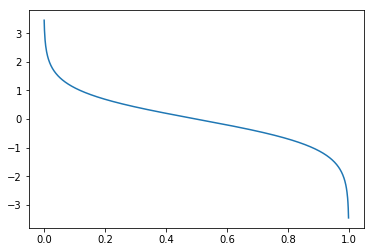

In [3]:
plt.plot(x,y)
plt.show()

#### 构造简单数据集并显示

In [4]:
def show_img(r,c,imgid,x,y1,y2,y1_name,y2_name,title_name,x_name,y_name,y_lim,legend_name,x_scale_log=False,y_lim_min=0):
    fig=plt.figure()
    ax=fig.add_subplot(r,c,imgid)
    ax.plot(x,y1,label=y1_name)
    ax.plot(x,y2,label=y2_name)
    #ax.set_xscale(x_name)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(title_name)
    ax.set_ylim(y_lim_min,y_lim)
    if x_scale_log==True:
        ax.set_xscale('log')
    ax.legend(loc=legend_name)
    plt.show()


In [5]:
def loadSimpData():
    datMat = np.matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [6]:
X_train,y_train=loadSimpData()

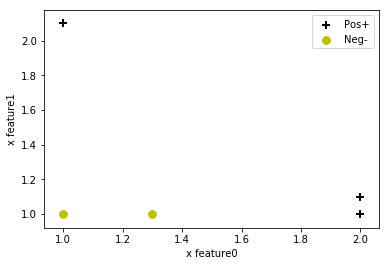

In [7]:
axes = plt.gca()
y_train=np.matrix(y_train)
#print(y_train.shape)
    # 这里用之前的矩阵的方法总有个错误,无奈,我们自己轮询找一下
    #neg = np.where(y_train==-1.0)
    #pos = np.where(y_train==1.0)
    #neg=neg[0]
    #pos=pos[0]
neg=[]
pos=[]
#print("ytrain",y_train[0,1]) # 这里调试一下合适的规则
for i in range(y_train.shape[1]):
    if y_train[0,i]==-1.0:
        neg.append(i)
    elif y_train[0,i]==1:
        pos.append(i)
X_neg=np.zeros([len(neg),2],np.float32)
X_pos=np.zeros([len(pos),2],np.float32)
for i in range(len(neg)):
    X_neg[i]=X_train[neg[i]]
for i in range(len(pos)):
    X_pos[i]=X_train[pos[i]]
axes.scatter(X_pos[:,0], X_pos[:,1], marker='+', c='k', s=60, linewidth=2, label="Pos+")
axes.scatter(X_neg[:,0], X_neg[:,1], c='y', s=60, label="Neg-")
axes.set_xlabel("x feature0")
axes.set_ylabel("x feature1")
axes.legend(frameon= True, fancybox = True);
plt.show()

In [8]:
# 判断DataM数据集的dimen维度值和threshVal的大小比较.
# threshIneq是比较的方式,大于阈值或者小于阈值.
# 返回一个predict
def stumpClassfy(DataM,dimen,threshVal,threshIneq):
    # create for saving status
    retArray=np.ones((DataM.shape[0],1),np.float32)
    if threshIneq=='lt':
        # <=
        retArray[DataM[:,dimen]<=threshVal]=-1.0
    else:
        retArray[DataM[:,dimen]>threshVal]=-1.0
    return retArray

In [9]:
# D: data's weights
# accroding to D ,get the lest error decision tree stump
# 本函数使用时D集合内容是不变的.
# 我们在对""合理范围内"的所有"阈值穷尽lt或者gt,来算错误的样本对应的D的值之和.
# 有点绕,参照log和代码好好理解.
def buildStump(DataM,y,D):
    m,n=DataM.shape
    minError=np.inf
    # for every features
    featureStep=10.0
    bestStump={}
    for i in range(n):
        featureMin=DataM[:,i].min()
        featureMax=DataM[:,i].max()
        featureStepSize=(featureMax-featureMin)/featureStep
        for j in range(-1,int(featureStep)+1):
            # for every step 
            for inequal in ['gt','lt']:
                # for every inequal
                threshVal=featureMin+float(j)*featureStepSize
                predict=stumpClassfy(DataM,i,threshVal=threshVal,threshIneq=inequal)
                # 对于所有样本.
                # 每个特征.
                #    对每个特征都有一个阈值和('gt' or 'lt')的算子. 算出对应的一个预期.
                #    如果这个算出的预期和实际的label一样.
                #        我们把errorItemIndexArray对应的项清零.以便后期乘法操作让这些正确的项不起作用.
                #    对于算出的预期和实际的label不一样的:
                #        errorItemIndexArray中会保持对应的错误项为1.在后面AdaBoost的调整alpha和D时候会有乘法操作.
                errorItemIndexArray=np.mat(np.ones((m,1),np.float32))
                #print("y")
                #print(y)
                #print(y.shape)
                # the correct item mask to Zero
                errorItemIndexArray[predict==y.transpose()]=0 # y的shape需要转置
                all_incorrect_weight_sum=D.T*errorItemIndexArray # 对于某个特定的特征,算出一共有多少个样本是错误的.
                #print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, all_incorrect_weight_sum))
                
                # 对于一套D和alpha.
                #    算出所有组合的,最小的错误项的那种组合.
                # 这样外面会受到这个结果,根据这个结果来调整D和alpha.
                if all_incorrect_weight_sum<minError: # 找到最小的错误项.
                    minError=all_incorrect_weight_sum
                    bestClsEst=predict
                    bestStump['dim']=i
                    bestStump['thresh']=threshVal
                    bestStump['ineq']=inequal
    
    return bestStump,minError,bestClsEst

D=np.ones((5,1),np.float32)/5
buildStump(X_train,y_train,D)             
    

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[ 0.2]], dtype=float32),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]], dtype=float32))

#### log的理解
```python
D=np.ones((5,1),np.float32)/5
buildStump(X_train,y_train,D) 

split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.60, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.60, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.70, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.70, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.80, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.80, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.90, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.90, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 2.00, thresh ineqal: gt, the weighted error is 0.400
split: dim 0, thresh 2.00, thresh ineqal: lt, the weighted error is 0.600
split: dim 1, thresh 0.89, thresh ineqal: gt, the weighted error is 0.600
split: dim 1, thresh 0.89, thresh ineqal: lt, the weighted error is 0.400
split: dim 1, thresh 1.00, thresh ineqal: gt, the weighted error is 0.800
split: dim 1, thresh 1.00, thresh ineqal: lt, the weighted error is 0.200
split: dim 1, thresh 1.11, thresh ineqal: gt, the weighted error is 0.600
split: dim 1, thresh 1.11, thresh ineqal: lt, the weighted error is 0.400
split: dim 1, thresh 1.22, thresh ineqal: gt, the weighted error is 0.600
split: dim 1, thresh 1.22, thresh ineqal: lt, the weighted error is 0.400
split: dim 1, thresh 1.33, thresh ineqal: gt, the weighted error is 0.600
split: dim 1, thresh 1.33, thresh ineqal: lt, the weighted error is 0.400
split: dim 1, thresh 1.44, thresh ineqal: gt, the weighted error is 0.600
split: dim 1, thresh 1.44, thresh ineqal: lt, the weighted error is 0.400
split: dim 1, thresh 1.55, thresh ineqal: gt, the weighted error is 0.600
split: dim 1, thresh 1.55, thresh ineqal: lt, the weighted error is 0.400
split: dim 1, thresh 1.66, thresh ineqal: gt, the weighted error is 0.600
split: dim 1, thresh 1.66, thresh ineqal: lt, the weighted error is 0.400
split: dim 1, thresh 1.77, thresh ineqal: gt, the weighted error is 0.600
split: dim 1, thresh 1.77, thresh ineqal: lt, the weighted error is 0.400
split: dim 1, thresh 1.88, thresh ineqal: gt, the weighted error is 0.600
split: dim 1, thresh 1.88, thresh ineqal: lt, the weighted error is 0.400
split: dim 1, thresh 1.99, thresh ineqal: gt, the weighted error is 0.600
split: dim 1, thresh 1.99, thresh ineqal: lt, the weighted error is 0.400
split: dim 1, thresh 2.10, thresh ineqal: gt, the weighted error is 0.400
split: dim 1, thresh 2.10, thresh ineqal: lt, the weighted error is 0.600
Out[92]:
({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[ 0.2]], dtype=float32),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]], dtype=float32))
```

### 单层决策树的AdaBoost训练

In [10]:
# numIt: iteration epoch
def adaBoostTrainDB(DataM,y,numIt=40):
    weakClassArr=[]
    m,n=DataM.shape
    D=np.ones((m,1),np.float32)/m
    aggClassEst=np.ones((m,1),np.float32)
    for i in range(numIt):
        #print("D:",D.T)
        bestStump,minError,bestClsEst=buildStump(DataM=DataM,y=y,D=D)
        alpha=float(0.5*np.log((1-minError)/max(minError,1e-16))) # 1e-16避免除数为零
        bestStump['alpha']=alpha
        weakClassArr.append(bestStump)
        #print("ClsEst: ",bestClsEst.T)
        #更新D,对于评估正确的样本和评估错误的样本有不同的更新公式
        expon=np.multiply(-1*alpha*y.T,bestClsEst)
        D=np.multiply(D,np.exp(expon))
        D=D/np.sum(D)
        aggClassEst+=alpha*bestClsEst
        #print("aggClassEst: ",aggClassEst.T)
        
        # 取出最小误差的那次预测的结果和label的差异的个数.
        # 每次D都更新,按照每次的D算出这次的结果.
        aggErrors=np.multiply(np.sign(aggClassEst)!=y,np.ones((m,1),np.float32)) 
        errorRate=np.sum(aggErrors)/m
        print("total error: ",errorRate)
        if errorRate==0:
            break
    
    return weakClassArr
    
    

In [14]:
weak_cls=adaBoostTrainDB(X_train,y_train,9)

total error:  2.0
total error:  2.4
total error:  2.0
total error:  2.4
total error:  2.4
total error:  2.4
total error:  2.4
total error:  2.4
total error:  2.4


#### log及分析
```python
D: [[ 0.2  0.2  0.2  0.2  0.2]]
ClsEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[ 0.30685282  1.69314718  0.30685282  0.30685282  1.69314718]]
total error:  2.0
D: [[ 0.5    0.125  0.125  0.125  0.125]]
ClsEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 1.27980781  2.66610217 -0.66610223 -0.66610223  0.72019213]]
total error:  2.4
D: [[ 0.28571429  0.07142857  0.07142857  0.07142857  0.5       ]]
ClsEst:  [[ 1.  1.  1.  1.  1.]]
aggClassEst:  [[ 2.17568755  3.56198192  0.22977751  0.22977751  1.61607194]]
total error:  2.0
D: [[ 0.16666667  0.04166667  0.25        0.25        0.29166667]]
ClsEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[ 1.37096858  4.36670113 -0.57494146 -0.57494146  2.42079091]]
total error:  2.4
D: [[ 0.5    0.025  0.15   0.15   0.175]]
ClsEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 2.14626741  5.14199972 -1.35024023 -1.35024023  1.6454922 ]]
total error:  2.4
D: [[ 0.3030303   0.01515152  0.09090909  0.09090909  0.5       ]]
ClsEst:  [[ 1.  1.  1.  1.  1.]]
aggClassEst:  [[ 2.89830613  5.8940382  -0.59820151 -0.59820151  2.39753103]]
total error:  2.4
D: [[ 0.18518519  0.00925926  0.25        0.25        0.30555556]]
ClsEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[ 2.15750384  6.63484049 -1.3390038  -1.3390038   3.13833332]]
total error:  2.4
D: [[ 0.5         0.00568182  0.15340909  0.15340909  0.1875    ]]
ClsEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 2.89067245  7.36800909 -2.0721724  -2.0721724   2.40516472]]
total error:  2.4
D: [[ 0.30769231  0.0034965   0.09440559  0.09440559  0.5       ]]
ClsEst:  [[ 1.  1.  1.  1.  1.]]
aggClassEst:  [[ 3.61954904  8.09688568 -1.34329581 -1.34329581  3.13404131]]
total error:  2.4
Out[106]:
[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471824645996},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550756160306},
 {'dim': 0,
  'thresh': 0.90000000000000002,
  'ineq': 'lt',
  'alpha': 0.8958797358837971},
 {'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.8047189554551886},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.7752987062715455},
 {'dim': 0,
  'thresh': 0.90000000000000002,
  'ineq': 'lt',
  'alpha': 0.7520386982470516},
 {'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.7408022704447926},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.7331685343611956},
 {'dim': 0,
  'thresh': 0.90000000000000002,
  'ineq': 'lt',
  'alpha': 0.7288766625388551}]
```

### 需要一个测试分类的方法


In [35]:
# X: 样本
# weakClassArr: 
#      是个List, 成员是 beatStump,共epoch个.
#      在某组epoch中找到的错误率最小的D的分类器.
#      包含了weakClassArr.append(bestStump)
#           bestStump中包含了: dim, thresh, ineq, alpha.
#
#       epoch(这里是9)个weak cls.
#            每个cls都对所有样本计算出一个predict值.
#            每个cls乘以其alpha的和得到一个投票的结果.
def adaClassify(X,weakClassArr):
    m,n=X.shape
    cls_val=np.zeros((m,1),np.float32)
    for i in range(len(weakClassArr)):
        predict=stumpClassfy(X,weakClassArr[i]['dim'],weakClassArr[i]['thresh'],weakClassArr[i]['ineq'])
        cls_val+=weakClassArr[i]['alpha']*predict # alpha是个常量
    print("cls_val",cls_val)
    return np.sign(cls_val)
    

In [36]:
adaClassify(X_train,weak_cls)

cls_val [[ 2.6195488 ]
 [ 7.09688568]
 [-2.34329581]
 [-2.34329581]
 [ 2.13404131]]


array([[ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.]], dtype=float32)

In [37]:
print(y_train.transpose())

[[ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


In [38]:
def loadDataSet(filename):
    num_feature=len(open(filename).readline().split('\t'))
    dataMat=[]
    labelMat=[]
    fr=open(filename)
    for line in fr.readlines(): # 注意这里 readline 和 readlines 的区别
        curline=line.strip().split('\t')
        lineArr=[] # 是个list
        #print(curline)
        for i in range(num_feature-1):
            #print("i:%s/num_feature:%s"%(i,num_feature))
            lineArr.append(float(curline[i])) # 注意这个转成float型
        dataMat.append(lineArr)
        labelMat.append(float(curline[-1]))
    return dataMat,labelMat

In [39]:
X_horse_train,y_horse_train=loadDataSet('horseColicTraining2.txt')

In [40]:
X_horse_train=np.mat(X_horse_train)
y_horse_train=np.mat(y_horse_train)
horse_weakcls=adaBoostTrainDB(X_horse_train,y_horse_train,numIt=40)

total error:  121.0
total error:  121.0
total error:  125.003344482
total error:  124.431438127
total error:  124.431438127
total error:  124.81270903
total error:  125.003344482
total error:  125.384615385
total error:  125.003344482
total error:  125.384615385
total error:  125.193979933
total error:  125.765886288
total error:  125.193979933
total error:  125.575250836
total error:  125.575250836
total error:  125.384615385
total error:  125.384615385
total error:  125.765886288
total error:  125.193979933
total error:  126.147157191
total error:  125.765886288
total error:  126.719063545
total error:  125.956521739
total error:  125.765886288
total error:  125.193979933
total error:  125.956521739
total error:  125.575250836
total error:  126.528428094
total error:  125.384615385
total error:  127.100334448
total error:  125.575250836
total error:  126.909698997
total error:  125.956521739
total error:  126.909698997
total error:  126.719063545
total error:  127.2909699
total error

In [41]:
X_horse_test,y_horse_test=loadDataSet('horseColicTest2.txt')

In [43]:
X_horse_test=np.mat(X_horse_test)
y_horse_test=np.mat(y_horse_test)
prediction=adaClassify(X_horse_test,horse_weakcls)
errArray=np.ones((67,1),np.float32)
error_cnt=np.sum(errArray[prediction!=y_horse_test.T])
print("error_cnt",error_cnt)

cls_val [[ 0.95461994]
 [ 1.27098572]
 [ 0.24258699]
 [-1.83685923]
 [ 0.44521946]
 [ 0.84903187]
 [ 0.25492656]
 [ 1.88878703]
 [ 1.33263063]
 [-1.40148723]
 [-0.16094241]
 [-0.31095886]
 [-0.55424923]
 [ 0.79479033]
 [ 0.13746494]
 [ 0.41450995]
 [ 0.64119607]
 [-1.15582049]
 [-0.6155476 ]
 [-0.52989906]
 [-0.78573483]
 [ 0.4846229 ]
 [-1.34943891]
 [-1.79574764]
 [ 2.52829361]
 [ 1.74962151]
 [ 1.86922157]
 [ 0.56389803]
 [ 1.86355793]
 [ 0.47905761]
 [ 2.29477835]
 [-1.08819163]
 [-1.21990478]
 [-0.42865914]
 [-1.03391707]
 [-0.20262909]
 [ 1.27783787]
 [ 1.79265273]
 [ 1.55965149]
 [ 1.37386739]
 [ 0.91737193]
 [ 1.54512274]
 [-0.31167668]
 [-1.2825191 ]
 [-1.38776922]
 [ 0.15951444]
 [-0.87272936]
 [ 1.07160735]
 [ 0.61285913]
 [-0.88237816]
 [-0.76225942]
 [ 1.64420426]
 [ 1.4867717 ]
 [ 1.02018797]
 [ 1.09440732]
 [ 1.14154875]
 [ 0.79844934]
 [-0.39068305]
 [ 0.97649485]
 [-1.8804816 ]
 [ 1.60401261]
 [-0.76225942]
 [ 0.05936576]
 [ 1.91698158]
 [ 1.21404517]
 [ 0.84129637]
 [

### 绘制ROC曲线

In [44]:
import matplotlib.pyplot as plt

In [47]:
# predStrengths: X_test在AdaClassify的预测值
# classLabels: y_test的
def plotROC(predStrengths,classLabels):
    cur=(1.0,1.0)
    ySum=0.0
    numPos=np.sum(np.array(classLabels)==1.0)
    yStep=1/float(numPos)
    xStep=1/float(len(classLabels)-numPos) # 为啥是互补的?
    sortedIndices=predStrengths.argsort()
    fig=plt.figure()
    fig.clf()
    ax=plt.subplot(1,1,1)
    for index in sortedIndices.tolist()[0]:
        if classLabels[index]==1.0:
            delatX=0
            delatY=yStep
        else:
            delatX=xStep
            delatY=0
            ySum+=cur[1]
        ax.plot([cur[0],cur[0]-delatX],[cur[1],cur[1]-delatY],c='b')
        cur=(cur[0]-delatX,cur[1]-delatY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print ("the Area Under the Curve is: ",ySum*xStep)
    
    

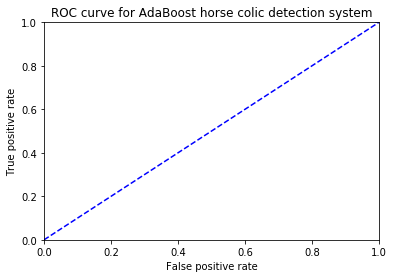

the Area Under the Curve is:  0.008264462809917356


In [49]:
plotROC(prediction,y_horse_train.T)